author: @SteveEckel

This example creates a spin-1/2 hamiltonian using spherical tensor algebra,
and compares it against the standard spin-1/2 hamiltonian generated from
the Pauli matrices.  This tests to make sure that the tensor algebra is
working properly, and that all minus signs are accounted for.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
from scipy.integrate import solve_ivp
from sympy.physics.wigner import wigner_3j, wigner_6j, wigner_9j
import pylcp
from pylcp.common import cart2spherical, spherical2cart, spherical_dot
plt.style.use('paper')

### Test various dot products:

In [2]:
a = np.array([1., 1j, 0])/np.sqrt(2)
print('Custom: ', spherical_dot(cart2spherical(a),cart2spherical(a)))
print('numpy vdot (spherical): ', np.vdot(cart2spherical(a),cart2spherical(a)))
print('numpy dot (cartesian):', np.dot(a, a))
print('numpy vdot (cartesian):', np.vdot(a, a))

Custom:  0j
numpy vdot (spherical):  (0.9999999999999996+0j)
numpy dot (cartesian): 0j
numpy vdot (cartesian): (0.9999999999999998+0j)


### Define the problem with the built-in spherical tensor functions.
The fun thing about this function is that it returns the $\mu_q$ matrices in a basis that is
opposite the standard Pauli matrices (spin down, spin up) rather than
(spin up, spin down).  But whatever.

Note as well that $gF > 0$ implies the magnetic moment is OPPOSITE F.  If the
magnetic moment is opposite the spin, then it will rotate clockwise when viewed
from the tip of the magnetic field vector.

[[<matplotlib.lines.Line2D at 0x151ed10350>],

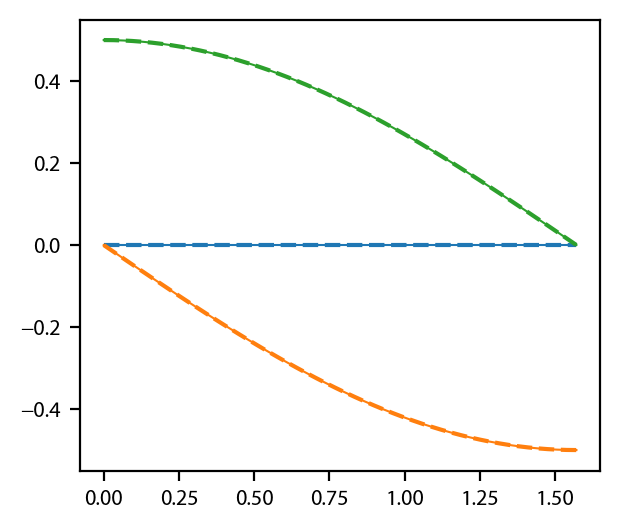

In [4]:
B = np.array([1., 0., 0.])

gF = 1 # See note above
H_0, mu_q, basis = pylcp.hamiltonians.singleF(1/2, gF=gF, muB=1, return_basis=True)

mu = spherical2cart(mu_q)
S = -mu/gF

# Next, define the Paul matrices:
S_pauli = np.zeros(mu_q.shape, dtype='complex128')
S_pauli[0] = np.array([[0., 1.], [1., 0.]])/2
S_pauli[1] = np.array([[0., -1j], [1j, 0.]])/2
S_pauli[2] = np.array([[1., 0.],[0., -1.]])/2

mu_pauli = -gF*S_pauli # Note muB=1 above.

# Tensor algebra from Wikipedia (https://en.wikipedia.org/wiki/Spherical_basis):
Bq = np.array([(B[0]-1j*B[1])/np.sqrt(2), B[2], -(B[0]+1j*B[1])/np.sqrt(2)])
H = np.tensordot(-mu_q, np.conjugate(Bq), axes=(0, 0))
# From Brown and Carrington:
"""Bq = np.array([(B[0]-1j*B[1])/np.sqrt(2), B[2], -(B[0]+1j*B[1])/np.sqrt(2)])
H = -spherical_dot(mu_q, cart2spherical(B))"""

# The Hamiltonian from the Pauli matrices.  Duh
H_pauli = -np.tensordot(mu_pauli, B, axes=(0, 0))

#print(H)
#print(H2)

# Evolve both:
sol = solve_ivp(lambda t, x: -1j*H @ x, [0, np.pi/2], np.array([0., 1.]).astype('complex128'),
                t_eval = np.linspace(0, np.pi/2, 50))
sol_pauli = solve_ivp(lambda t, x: -1j*H_pauli @ x, [0, np.pi/2],
                      np.array([1., 0.]).astype('complex128'),
                      t_eval = np.linspace(0, np.pi/2, 50))

# Compute expectation values:
avS = np.zeros((3, sol.t.size))
avS_pauli = np.zeros((3, sol.t.size))
for ii in range(3):
    for jj in range(sol.t.size):
        avS[ii, jj] = np.real(np.conjugate(sol.y[:, jj].T)@S[ii]@sol.y[:, jj])
        avS_pauli[ii, jj] = np.real(np.conjugate(sol_pauli.y[:, jj].T)@
                                    S_pauli[ii]@sol_pauli.y[:, jj])

fig, ax = plt.subplots(1, 1)
[ax.plot(sol.t, avS[jj], linewidth=0.75, color='C%d'%jj) for jj in range(3)]
[ax.plot(sol.t, avS_pauli[jj], '--', color='C%d'%jj) for jj in range(3)]